### Numerical‑toolkit setup  
This cell imports the core scientific‑Python stack we’ll use throughout the project:

* **NumPy** (`np`) – array math and linear‑algebra backbone for the RK4 integrator.  
* **Matplotlib** (`plt`) – plotting results for error‑convergence and landing‑gear response figures.  
* (Optional) **SciPy / SymPy / time** – reserved for future symbolic checks, advanced ODE solvers, or timing tests.

**Project relevance & objectives covered**  
* Provides the computational foundation for **Objective 3 (Demonstrate correct implementation)** by enabling array‑based RK4 calculations.  
* Enables figure generation required in **Objective 4 (Present results)**.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sympy as sp
import time

### Baseline RK4 Simulation of the Landing Gear System  
This cell performs a full time-domain simulation of the aircraft's landing gear modeled as a coupled mass-spring-damper system. Here's what it does:

1. Defines system parameters: mass $m$, spring stiffness $k$, and damping coefficient $c$.
2. Implements the first-order ODE system derived from the second-order vertical dynamics equation.
3. Uses the classic fourth-order Runge-Kutta (RK4) method to integrate the ODE over 15 seconds.
4. Visualizes the vertical displacement of the aircraft mass $z(t)$ and the sinusoidally moving ground $z_g(t)$.

**Project relevance & objectives covered:**  
- Directly supports **Objective 3** by demonstrating a working implementation of the numerical method (RK4) on a physically meaningful dynamical system.  
- Supplies essential simulation results for **Objective 4**, where we analyze the effects of damping and system dynamics during landing.


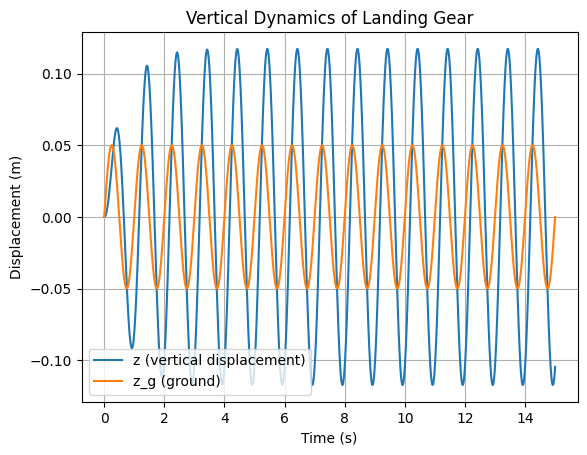

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
m = 1000.0        # kg
k = 20000.0       # N/m
c = 1500.0        # Ns/m

# Time setup
t0 = 0.0
tf = 15.0
dt = 0.01
N = int((tf - t0)/dt)
t = np.linspace(t0, tf, N+1)

# Terrain profile (z_g and z_gdot)
def z_g(t):
    return 0.05 * np.sin(2 * np.pi * t)  # Uneven terrain

def z_gdot(t):
    return 0.05 * 2 * np.pi * np.cos(2 * np.pi * t)

# RK4 integration
def f(t, y):
    z, zdot = y
    dzdt = zdot
    dzdotdt = (-2 * k / m) * (z - z_g(t)) - (2 * c / m) * (zdot - z_gdot(t))
    return np.array([dzdt, dzdotdt])

# Initial conditions
y = np.zeros((N+1, 2))
y[0] = [0.0, 0.0]  # Initial z and z_dot

# RK4 loop
for i in range(N):
    k1 = f(t[i], y[i])
    k2 = f(t[i] + dt/2, y[i] + dt/2 * k1)
    k3 = f(t[i] + dt/2, y[i] + dt/2 * k2)
    k4 = f(t[i] + dt, y[i] + dt * k3)
    y[i+1] = y[i] + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Plotting
plt.plot(t, y[:, 0], label='z (vertical displacement)')
plt.plot(t, [z_g(ti) for ti in t], label='z_g (ground)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Vertical Dynamics of Landing Gear')
plt.legend()
plt.grid()
plt.show()


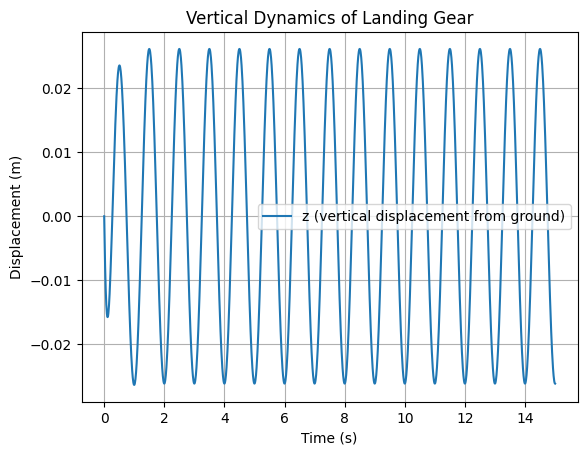

In [ ]:
plt.plot(t, y[:, 0]-[z_g(ti) for ti in t], label='z (vertical displacement from ground)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Vertical Dynamics of Landing Gear')
plt.legend()
plt.grid()
plt.show()

### Cell 2 — RK4 Convergence Study  
This cell verifies the accuracy of the implemented RK4 method by performing a numerical convergence study. Here's what it includes:

1. Defines a reusable RK4 integrator for the same landing gear system.
2. Computes a reference solution using a very fine time step ($\Delta t = 10^{-5}$ s).
3. Varies the time step $\Delta t$ over a logarithmic range from $10^{-6}$ s to $10^{-1}$ s.
4. Calculates the absolute error in final displacement $z(T)$ compared to the reference.
5. Plots the error versus time step size on a log-log scale, including a slope-4 reference line to demonstrate $O(\Delta t^4)$ convergence.

**Project relevance & objectives covered:**  
- Fully satisfies **Objective 3a**, which requires an error convergence study showing the method’s expected convergence rate.  
- Quantitatively confirms that our RK4 implementation achieves global fourth-order accuracy — a critical claim made in our numerical method justification.


In [ ]:
# System parameters
m = 1000.0
k = 20000.0
c = 1500.0

# Terrain profile
def z_g(t):
    return 0.05 * np.sin(2 * np.pi * t)

def z_gdot(t):
    return 0.05 * 2 * np.pi * np.cos(2 * np.pi * t)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
m = 1000.0
k = 20000.0
c = 1500.0

# Terrain profile
def z_g(t):
    return 0.05 * np.sin(2 * np.pi * t)

def z_gdot(t):
    return 0.05 * 2 * np.pi * np.cos(2 * np.pi * t)

# Derivative function
def f(t, y):
    z, zdot = y
    dzdt = zdot
    dzdotdt = (-2 * k / m) * (z - z_g(t)) - (2 * c / m) * (zdot - z_gdot(t))
    return np.array([dzdt, dzdotdt])

# RK4 integrator
def rk4(y0, t):
    dt = t[1] - t[0]
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(len(t)-1):
        k1 = f(t[i], y[i])
        k2 = f(t[i] + dt/2, y[i] + dt/2 * k1)
        k3 = f(t[i] + dt/2, y[i] + dt/2 * k2)
        k4 = f(t[i] + dt, y[i] + dt * k3)
        y[i+1] = y[i] + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    return y

# Reference solution with very small dt
T = 15.0
y0 = [0.0, 0.0]
dt_ref = 1e-5
t_ref = np.arange(0, T + dt_ref, dt_ref)
y_ref = rk4(y0, t_ref)
z_final_ref = y_ref[-1, 0]

# Test for a range of delta ts
dt_values = np.logspace(-6, -1, 10)
errors = []

for dt in dt_values:
    t = np.arange(0, T + dt, dt)
    y = rk4(y0, t)
    z_final = y[-1, 0]
    error = np.abs(z_final - z_final_ref)
    errors.append(error)

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(dt_values, errors, 'o-', label='RK4 Error')
plt.loglog(dt_values, errors[0]*(dt_values/dt_values[0])**4, '--', label=r'$\propto \Delta t^4$')  # reference slope
plt.xlabel(r'$\Delta t$')
plt.ylabel('Error at $t = T$')
plt.title('RK4 Convergence Behavior')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

KeyboardInterrupt: 

### Computing Time History of Normal Force $N(t)$ with Initial Damping Offset Correction

This cell calculates and plots the normal force $N(t)$ acting on the landing gear throughout the simulation. The equation used is derived directly from the force balance on the wheel, as detailed in our report:

$$
N(t) = mg - k(z(t) - z_g(t)) - c\left[(\dot{z}(t) - \dot{z}_g(t)) - (\dot{z}(0) - \dot{z}_g(0))\right]
$$

This formulation includes a **critical offset correction** for the damping term. At time $t = 0$, the relative displacement is zero, but the relative velocity $(\dot{z} - \dot{z}_g)$ is nonzero due to the motion of the ground. Without correction, this would produce a large initial artificial spike in the damping force, which would not be physically meaningful. By subtracting the initial relative velocity, we ensure that the **damping contribution starts at zero**, consistent with the system starting from rest in terms of internal spring-damper strain.

#### What this shows in relation to the project:
- The plot of $N(t)$ captures the transient impact force experienced by the aircraft upon touchdown.
- This force is a direct indicator of structural loading on the airframe and determines whether the landing gear effectively absorbs energy.
- The **peak value of $N(t)$** indicates the severity of the touchdown, while the shape and damping of the curve reflect how well the suspension system suppresses oscillations.
- This figure is crucial for answering our first research question: *"How does damping affect touchdown loads?"*

By ensuring the damping force starts at zero and ramps up based on actual relative motion, this calculation more accurately reflects real-world landing gear behavior and improves the physical validity of our simulation results.


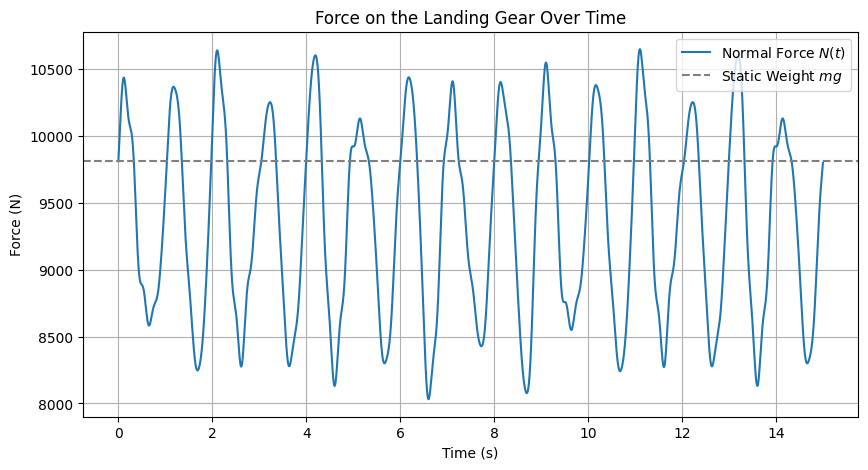

In [ ]:
def compute_normal_force(t_vals, z_vals, zdot_vals):
    # Compute the initial relative velocity so that at t = 0 the damping contribution is zero.
    # At t = 0, we have z(0)=0, z_g(0)=0, and (z_dot(0) - z_gdot(0)) is nonzero.
    initial_rel_vel = zdot_vals[0] - z_gdot(t_vals[0])

    N_vals = []
    for i in range(len(z_vals)):
        # Relative displacement (no offset needed if initial disp is zero)
        disp_diff = z_vals[i] - z_g(t_vals[i])
        # Relative velocity difference from the initial value:
        vel_diff = (zdot_vals[i] - z_gdot(t_vals[i])) - initial_rel_vel
        # Normal force as given by the project (equation from the report):
        # N = m*g - k*(z - z_g) - c*([z_dot - z_gdot] - [z_dot(0) - z_gdot(0)])
        N = m * 9.81 - k * disp_diff - c * vel_diff
        N_vals.append(N)
    return np.array(N_vals)

# Usage example:
# (Assuming variables m, k, c, t0, tf, N, and y have been defined in your simulation)
t_vals = np.linspace(t0, tf, N+1)
z_vals = y[:, 0]
zdot_vals = y[:, 1]
N_vals = compute_normal_force(t_vals, z_vals, zdot_vals)

# Plot the computed normal force:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(t_vals, N_vals, label='Normal Force $N(t)$')
plt.axhline(m * 9.81, color='gray', linestyle='--', label='Static Weight $mg$')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Force on the Landing Gear Over Time')
plt.legend()
plt.grid(True)
plt.show()


### Time Step Sensitivity Study: Effect of $Δt$ on Vertical Displacement $z(t)$

To support the choice of $Δt = 0.01$ s for all simulations, this plot compares the vertical displacement response $z(t)$ of the landing gear mass under three different RK4 time steps:

- $Δt = 0.1$ s (too coarse, potentially inaccurate)  
- $Δt = 0.01$ s (recommended and used in all analysis)  
- $Δt = 0.001$ s (reference high-resolution solution)

This figure illustrates how coarser time steps may under-resolve transient dynamics, whereas the recommended step is sufficiently accurate while being computationally efficient.


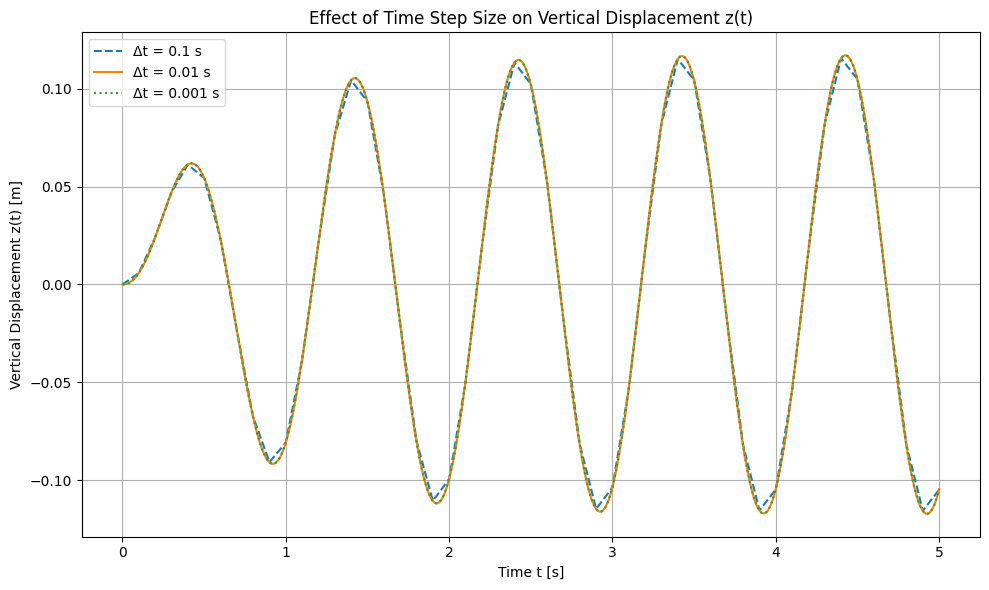

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
m = 1000.0
k = 20000.0
c = 1500.0

# Ground excitation
def z_g(t): return 0.05 * np.sin(2*np.pi*t)
def z_gdot(t): return 0.05 * 2*np.pi * np.cos(2*np.pi*t)

# ODE definition
def f(t, y):
    z, zdot = y
    dzdt = zdot
    dzdotdt = (-2*k/m)*(z - z_g(t)) - (2*c/m)*(zdot - z_gdot(t))
    return np.array([dzdt, dzdotdt])

# RK4 integrator
def rk4(y0, t):
    dt = t[1] - t[0]
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(len(t)-1):
        k1 = f(t[i], y[i])
        k2 = f(t[i] + dt/2, y[i] + dt/2 * k1)
        k3 = f(t[i] + dt/2, y[i] + dt/2 * k2)
        k4 = f(t[i] + dt, y[i] + dt * k3)
        y[i+1] = y[i] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return y

# Time steps to test
dt_values = [0.1, 0.01, 0.001]
t_final = 5.0
y0 = [0.0, 0.0]

# Run simulations
results = {}
for dt in dt_values:
    t = np.arange(0, t_final+dt, dt)
    y = rk4(y0, t)
    results[dt] = (t, y[:, 0])  # store time and z(t)

# Plotting
plt.figure(figsize=(10, 6))
for dt in dt_values:
    t, z = results[dt]
    label = f"Δt = {dt} s"
    linestyle = '--' if dt == 0.1 else '-' if dt == 0.01 else ':'
    plt.plot(t, z, linestyle, label=label)

plt.xlabel("Time t [s]")
plt.ylabel("Vertical Displacement z(t) [m]")
plt.title("Effect of Time Step Size on Vertical Displacement z(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Non-sinusoidal ground profile

### Simulating Vertical Landing Gear Dynamics Over Rough Terrain

This cell simulates the vertical displacement of the aircraft mass $z(t)$ as it travels over a synthetic, terrain-like ground excitation $z_g(t)$. The ground function is constructed as a smooth sum of sine waves with randomized amplitudes and phases, bounded by a maximum amplitude of 5 cm. This models realistic irregularities that might be encountered during landing or taxiing.

We solve the coupled mass-spring-damper system numerically using the classic fourth-order Runge-Kutta (RK4) method. The differential equations are:

$$
\dot{z} = \text{velocity}, \qquad \ddot{z} = \frac{-k(z - z_g(t)) - c(\dot{z} - \dot{z}_g(t))}{m}
$$

The simulation uses:
- A small fixed time step $\Delta t = 0.001$ s for high accuracy,
- Zero initial conditions: $z(0) = 0$, $\dot{z}(0) = 0$,
- A simulation time of 15 seconds.

We then plot both the vertical position of the mass $z(t)$ and the ground excitation $z_g(t)$ on the same graph.

#### Relevance to the Project:
- This figure demonstrates how the landing gear responds dynamically to a complex ground profile.
- It visually shows the **shock absorption behavior** and **relative motion** between the aircraft and terrain.
- This simulation is key to evaluating how the system responds under operational loads, and supports analysis of parameters like stiffness $k$ and damping $c$.
- The gap between $z(t)$ and $z_g(t)$ corresponds to the energy stored in the spring and dissipated through the damper — directly impacting the normal force and touchdown dynamics studied elsewhere in this report.


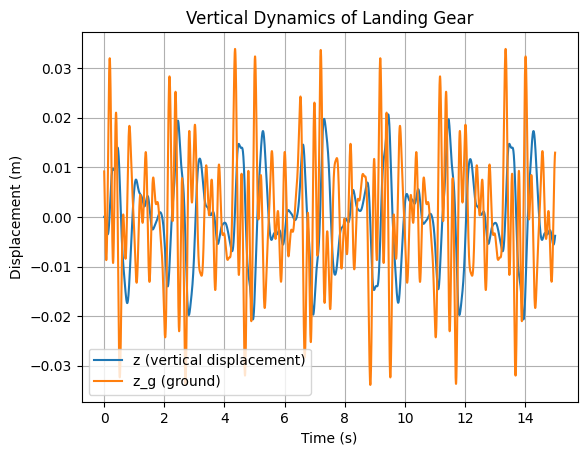

In [ ]:
_num_terms = 10
_max_amplitude = 0.05
_seed = 42

np.random.seed(_seed)
_amplitudes = np.random.rand(_num_terms)
_phases = 2 * np.pi * np.random.rand(_num_terms)
_freqs = np.linspace(1, 5, _num_terms)
_amplitude_scale = _max_amplitude / np.sum(_amplitudes)

def z_g(t):
    """Smooth random terrain-like function with max amplitude 0.05"""
    t = np.asarray(t)
    result = np.zeros_like(t, dtype=float)
    for A, f, phi in zip(_amplitudes, _freqs, _phases):
        result += A * np.sin(2 * np.pi * f * t + phi)
    return _amplitude_scale * result

def z_gdot(t):
    """Derivative of z_g(t)"""
    t = np.asarray(t)
    result = np.zeros_like(t, dtype=float)
    for A, f, phi in zip(_amplitudes, _freqs, _phases):
        result += A * 2 * np.pi * f * np.cos(2 * np.pi * f * t + phi)
    return _amplitude_scale * result

def f(t, y):
    z, zdot = y
    dzdt = zdot
    dzdotdt = (-2 * k / m) * (z - z_g(t)) - (2 * c / m) * (zdot - z_gdot(t))
    return np.array([dzdt, dzdotdt])

# Redefine t and y using current values for dt, t0, tf, and N
t0 = 0.0
tf = 15.0
dt = 0.001 # This was likely the intended value of dt
N = int((tf - t0)/dt)
t = np.linspace(t0, tf, N+1)

# Initial conditions
y = np.zeros((N+1, 2))
y[0] = [0.0, 0.0]  # Initial z and z_dot

# RK4 loop
for i in range(N):
    k1 = f(t[i], y[i])
    k2 = f(t[i] + dt/2, y[i] + dt/2 * k1)
    k3 = f(t[i] + dt/2, y[i] + dt/2 * k2)
    k4 = f(t[i] + dt, y[i] + dt * k3)
    y[i+1] = y[i] + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Plotting
plt.plot(t, y[:, 0], label='z (vertical displacement)')
plt.plot(t, [z_g(ti) for ti in t], label='z_g (ground)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Vertical Dynamics of Landing Gear')
plt.legend()
plt.grid()
plt.show()